# Music Analyzer
---
---

## Requirements
---

In [ ]:
"""Ressources"""
# https://www.classicalarchives.com (accessed: 27.12.2021)
"""MIDI Objects for Python"""
# https://mido.readthedocs.io/en/latest/
# pip install mido
"""Matplotlib"""
# pip install -U matplotlib

## Imports and loading the data
---

In [1]:
import mido
import os.path
import matplotlib.pyplot as plt

filename = "bwv030_8.mid"
data_path = os.path.join("data", filename)

# load midi file
mid = mido.MidiFile(data_path)

## Retrieve Information
---

In [2]:
# dictionary mapping midi value (keys) to associated note name (value)
note_value_dict = {
    0 : "C",
    1 : "C♯/D♭",
    2 : "D",
    3 : "D♯/E♭",
    4 : "E",
    5 : "F",
    6 : "F♯/G♭",
    7 : "G",
    8 : "G♯/A♭",
    9 : "A",
    10 : "A♯/B♭",
    11 : "B"
}
# get a list of all the note values, ranging from 0-127
# note name reference: https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies (accessed 31.12.2021) 
notes = [msg.note for msg in mid if msg.type == "note_on"]
# reducing frequency space complexity to the range of one octave
note_values_reduced = [note_value % 12 for note_value in notes]
# count note occurrences 
frequency_of_occurrence = {}
for note_value in note_value_dict.keys():
    frequency_of_occurrence[note_value_dict[note_value]] = note_values_reduced.count(note_value)
# sort dict by values (high to low)
sorted_dict = {k: v for k, v in sorted(frequency_of_occurrence.items(), key=lambda item: item[1], reverse=True)}

## Display information
---

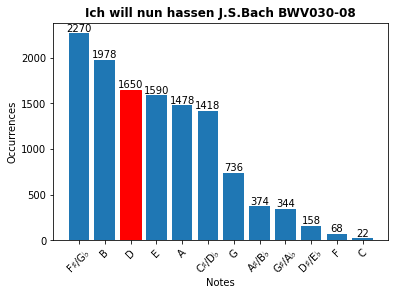

In [3]:
# helper method, trying to fetch key of piece if provided (track 0 usually contains meta data)
def get_key(midi_file):
    for msg in mid.tracks[0]:
        if msg.type == "key_signature":
            return msg.key
    return None

# helper method, trying to fetch title of piece if provided
def get_title(midi_file, verbose = False):
    title = []
    for msg in mid.tracks[0]:
        if msg.type == "track_name":
            title.append(msg.name)
        if msg.type == "text" and verbose:
            title.append(msg.text)
    if len(title) > 0:
        return " ".join(title).strip()
    else:
        return None

# create the plot from dictionary
barlist = plt.bar(sorted_dict.keys(), sorted_dict.values())
plt.ylabel("Occurrences")
plt.xlabel("Notes")
plt.xticks(rotation = 45)
# add exact count upon corresponding bar
ax = plt.gca()
plt.bar_label(ax.containers[0])

# add meta data if present
title_str = get_title(mid) 
if title_str is not None:
    plt.title(title_str, fontweight= "bold")

# highlight the root note
key = get_key(mid)
if key is not None and key in sorted_dict:
    barlist[list(sorted_dict.keys()).index(key)].set_color("red")

plt.show()

## Transposition
---

In [12]:
"""
    use this method to calculate the number of semitone steps between the given root note and the desired key
    
    NOTE: this method will transpose UPWARDS, e.g. get_tonal_distance('C', 'D') will return "2", not "10"
    
    NOTE: for convenience sharp and flat notes will be accepted separately, pointing to the same numeric value,
    additionally ASCII symbols are avoided and so the notes can be accessed by adding "s" or "f" to the note name, 
    e.g. "C♯" can be expressed as "Cs", same for example "Gf" will be interpreted as "G♭"

    will return "None" if note names don't match given syntax
"""
def get_tonal_distance(root: str, transpose_to: str) -> int:
    inverse_note_dict = {
        "C" : 0,
        "Cs": 1,
        "Df": 1,
        "D" : 2,
        "Ds" : 3,
        "Ef" : 3,
        "E" : 4,
        "F" : 5,
        "Fs" : 6,
        "Gf" : 6,
        "G" : 7,
        "Gs" : 8,
        "Af" : 8,
        "A" : 9,
        "As" : 10,
        "Bf" : 10,
        "B" : 11
    }
    if root in inverse_note_dict and transpose_to in inverse_note_dict:
        steps = 0
        while True:
            if (inverse_note_dict[root] + steps) % 12 == inverse_note_dict[transpose_to]:
                return steps
            steps += 1    
    else:
        return None    
    
"""use this method to transpose a given list of midi values by given amount of steps"""
def transpose(midi_values: list, steps: int) -> list:
    return [(note_value + steps) % 12 for note_value in midi_values]